# Churn within the Realm of Telecom

## Project Goals

- Discovers the biggest drivers of customer churn.  

- Use those drivers to develope machine learning models to accurately classify customers as either churned or not churned.

- Deliver a report that a non-techincal person can read and understand what steps were taken, why they were taken, and the outcomes from those steps.

# Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import acquire
import prepare

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.options.display.max_columns = None

# Acquire

- I obtained my data from the Codeup MySQL server, though this dataset is available online

- I got my data on 1/2/23

- The dataset is 7043 rows by 25 columns

- Each observation is an individual customer

- Each row represents something about that customer

In [8]:
#this pulls my data from the .csv file and 
#shows the first row, to get a feel for the columns
data = acquire.get_telco_data()

data.head(1)

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check


# Prepare

- After acquiring my data, the first thing I did was to replace empty spaces in the 'total_charges' column with zeroes, so that I could convert the data type to float.

- After that, I checked to see if there were any null values, or anything that might of significance that could skew my results. After performing some lines of code, I determined that there weren't any outliers of enough significance to drop them. I didn't run into any nulls.

- After that, I made dummy columns for all of my categorical columns to convert them into useful, numeric values. With a couple of the columns, like the 'multiple_lines' column, it created a dummy that wasn't helpful, called 'multiple_lines_No phone service', so I manually dropped those and then cleared out all of the columns that the dummies originated from, and concatenated the dummies together with the cleaned dataframe.

In [9]:
#this uses my function to clean the data and 
#shows the first row to compare to the uncleaned dataframe
data = prepare.prep_telco(data)

data.head(1)

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,contract_type,internet_service_type,churn_Yes,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_Yes,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,paperless_billing_Yes,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0002-ORFBO,0,9,65.6,593.3,One year,DSL,0,0,1,1,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1


In [11]:
#this separates my data into my train, validate, and test sets
train, val, test = prepare.split_train_test(data, 'churn_Yes')

In [12]:
#this is simply to confirm that the proportions of the sets look correct
train.shape, val.shape, test.shape

((3521, 30), (2113, 30), (1409, 30))

# Explore

## Is whether or not a customer churns dependent of their internet service type?

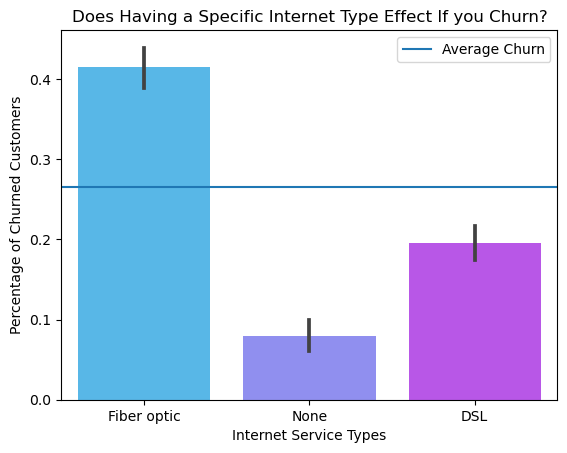

In [15]:
#This block of code creates by bar chart
sns.barplot(x='internet_service_type', y='churn_Yes', 
            data=train, palette='cool')
#I'm creating a line that goes across the chart that shows the average
churn_rate = train.churn_Yes.mean()
plt.axhline(churn_rate, label="Average Churn")

#creating labels and a title
plt.title('Does Having a Specific Internet Type Effect If you Churn?')
plt.xlabel('Internet Service Types')
plt.ylabel('Percentage of Churned Customers')

#making sure the legend appears
plt.legend()
plt.show()

- The main takeaway here is that it really seems like there is a realtionship between churn and internet service type.

- The other point to note is that this might indicate there are improvements that can be made for the fiber optic customers.

For this question, I decided it would be useful to dig deeper and perform a statistical test to help back up my assumptions. Since we are talking about two categorical variables here, I used a chi-square test to determine if there was a relationship.

My $H_a$ here is that there is **no** significant relationship between churn and internet service types.

My $H_o$ is that there **is** a relationship of significance.

In [16]:
#creating a crosstab of the relevant data to prepare for my test

observed = pd.crosstab(train.internet_service_type, train.churn_Yes)

In [17]:
#confirming it worked by showing the crosstab
#0 here being not having churned and 1 meaning yes
observed

churn_Yes,0,1
internet_service_type,,
DSL,998,242
Fiber optic,892,632
None,697,60


In [19]:
#setting my alpha to determine how accurate I want to be
alpha = 0.05

In [18]:
#the next step of the chi2 test
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [20]:
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')
print('Is p-value < alpha?', p < alpha)

Observed Values

[[998 242]
 [892 632]
 [697  60]]
---
Expected Values

[[ 911  328]
 [1119  404]
 [ 556  200]]
---

chi^2 = 340.2563
p     = 0.0000
Is p-value < alpha? True


So in this test, my p-value is extremely low, which indicates thats its highly likely that there **is** a significant relationship between churn and internet service type. Thus, with this, we can reject our null hypothesis. This would make this an excellent driver for churn to use in our modeling.

## What is the relationship between phone service and churn?

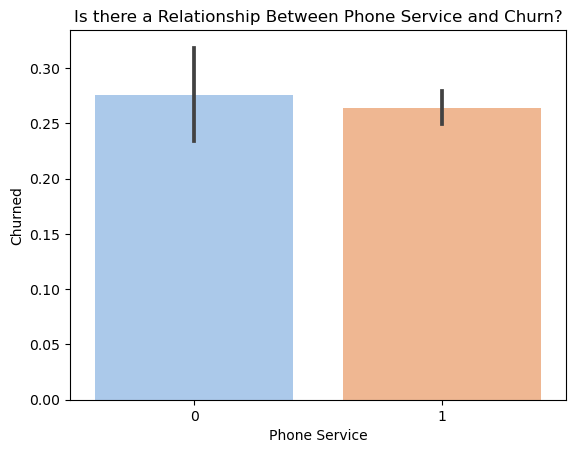

In [27]:
#code to create the barplot
sns.barplot(x='phone_service_Yes', 
            y='churn_Yes', data=train,
            palette='pastel')

#creating labels and a title
plt.title('Is there a Relationship Between Phone Service and Churn?')
plt.xlabel('Phone Service')
plt.ylabel('Churned')

plt.show()

- The number of customers who had phone service and churned compared to the number who didn't have phone service and churned is close enough that I decided to move on to my next question.

- Because there appears to be no real significance, this wouldn't make a good driver for our models.

## Do monthly charges differ for different contract types?

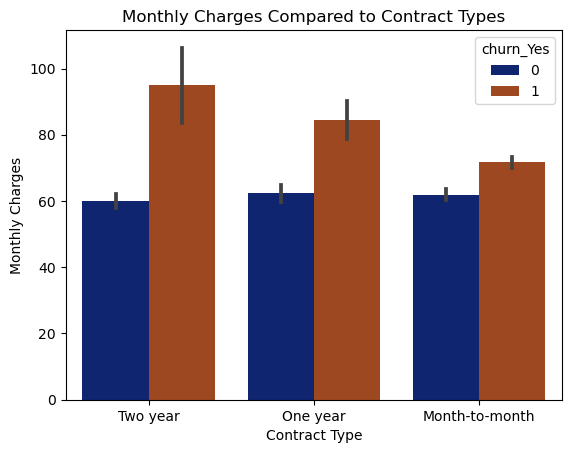

In [29]:
#creating the plot
sns.barplot(x='contract_type', y='monthly_charges',
            hue='churn_Yes', data=train, palette='dark')

#creating labels and the title
plt.title('Monthly Charges Compared to Contract Types')
plt.xlabel('Contract Type')
plt.ylabel('Monthly Charges')

plt.show()

- My main takeaway from this visual is that, generally, if someones bill increases from the average, they are more likely to churn.

- This is exactly what I would have expected, and decided not to dig deeper, but to make sure I use this data with my models.

- This feature will be a driver that is worthy of using when it comes to modeling.

## Are contract type and churn status related?

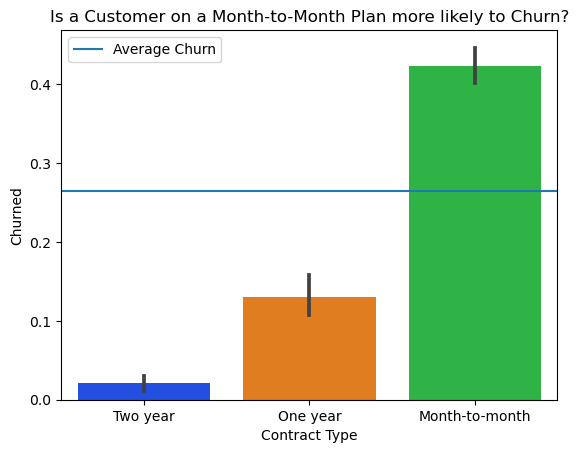

In [31]:
#creating my bar plot
sns.barplot(x='contract_type', y='churn_Yes', 
            data=train, palette='bright')

#creating the average to visualize it as a line across the chart
churn_rate = train.churn_Yes.mean()
plt.axhline(churn_rate, label="Average Churn")

#creating my labels and title
plt.title('Is a Customer on a Month-to-Month Plan more likely to Churn?')
plt.xlabel('Contract Type')
plt.ylabel('Churned')

plt.legend()
plt.show()

- My main takeaway here is that month-to-month customers churn **way** more frequently than other customers.

- It seems very likely there is a relationship here, but to confirm, I performed another statistical test.

### The Statistical test

- Since I am, again, comparing two categorical variables, I used another chi squared test.

My $H_a$ is that there is **no** significant relationship here.

My $H_o$ is the opposite, that there **is**.

In [32]:
#creating my crosstab
observed2 = pd.crosstab(train.contract_type, train.churn_Yes)

#viewing the crosstab
observed2

churn_Yes,0,1
contract_type,,
Month-to-month,1116,821
One year,634,95
Two year,837,18


In [33]:
#the next step, creating variables for and running the test

chi2, p, degf, expected = stats.chi2_contingency(observed2)

In [34]:
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(observed.values)
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')

print('Is p-value < alpha?', p < alpha)

Observed Values

[[998 242]
 [892 632]
 [697  60]]
---
Expected Values

[[1423  513]
 [ 535  193]
 [ 628  226]]
---

chi^2 = 579.6972
p     = 0.0000
Is p-value < alpha? True


As with my earlier test, my alpha value to compare to is 0.05. 

For this test, when comparing the generated p-value to my alpha, it ends up being significantly smaller. This indicates, like above, that there **is** a significant relationship between churn and contract type. This, of course, means that we can reject our null hypothesis. All of this would make contract type a great driver for customer churn.

## Exploration Summary

